# Example 1. DANN
This notebook reproduces the experiment from [Unsupervised Domain Adaptation by Backpropagation](https://arxiv.org/abs/1409.7495). We then use it as a GAN-powered benchmark of domain adaptation for **MNIST** --> **MNIST-M** datasets.

*[Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Oleg Ovcharenko](https://ovcharenkoo.com/), 2021. "Direct domain adaptation through mutual linear transformations"*

-------
This code is modified from [https://github.com/fungtion/DANN_py3](https://github.com/fungtion/DANN_py3). 

In [2]:
import os
import sys
import random
import numpy as np

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

from components.data_loader import GetLoader
from components.model import CNNModel
from components.test import test
import components.shared as sd

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Init paths

In [4]:
# Paths to datasets
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
os.makedirs('./dataset', exist_ok=True)

# Where to save outputs
model_root = './out_ex1_dann'
os.makedirs(model_root, exist_ok=True)

### Init training

In [5]:
cuda = True
cudnn.benchmark = True

# Hyperparameters
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

# manual_seed = random.randint(1, 10000)
manual_seed = 222
random.seed(manual_seed)
torch.manual_seed(manual_seed)
print(f'Random seed: {manual_seed}')

Random seed: 222


### Data

In [6]:
# Transformations / augmentations
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load MNIST dataset
dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

# Load MNIST-M dataset
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

# Init dataloaders
dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

### Network

In [7]:
# Init network
my_net = CNNModel()

# Optimizer
optimizer = optim.Adam(my_net.parameters(), lr=lr)

# Losses
loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True

In [8]:
# Record losses for each epoch (used in compare.ipynb)
losses = {'test': {'acc_bw': [], 'acc_color': []}}
name_losses = 'losses.pkl'

### Training

Losses from previous run found!
Load dict from ./out_ex1_dann/losses.pkl


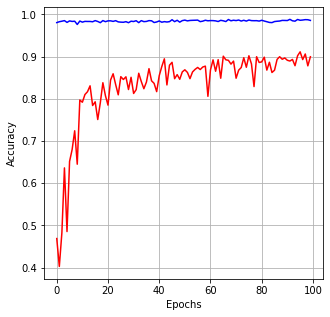

In [9]:
# training
if not name_losses in os.listdir(model_root):
# if True:
    best_accu_t = 0.0
    for epoch in range(n_epoch):

        len_dataloader = min(len(dataloader_source), len(dataloader_target))
        data_source_iter = iter(dataloader_source)
        data_target_iter = iter(dataloader_target)

        for i in range(len_dataloader):

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # training model using source data
            data_source = data_source_iter.next()
            s_img, s_label = data_source

            my_net.zero_grad()
            batch_size = len(s_label)

            domain_label = torch.zeros(batch_size).long()

            if cuda:
                s_img = s_img.cuda()
                s_label = s_label.cuda()
                domain_label = domain_label.cuda()


            class_output, domain_output = my_net(input_data=s_img, alpha=alpha)
            err_s_label = loss_class(class_output, s_label)
            err_s_domain = loss_domain(domain_output, domain_label)

            # training model using target data
            data_target = data_target_iter.next()
            t_img, _ = data_target

            batch_size = len(t_img)

            domain_label = torch.ones(batch_size).long()

            if cuda:
                t_img = t_img.cuda()
                domain_label = domain_label.cuda()

            _, domain_output = my_net(input_data=t_img, alpha=alpha)
            err_t_domain = loss_domain(domain_output, domain_label)
            err = err_t_domain + err_s_domain + err_s_label
            err.backward()
            optimizer.step()

            sys.stdout.write('\r epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
                  % (epoch, i + 1, len_dataloader, err_s_label.data.cpu().numpy(),
                     err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
            sys.stdout.flush()
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_current.pth'.format(model_root))

        print('\n')
        accu_s = test(source_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f' % ('mnist', accu_s))
        accu_t = test(target_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f\n' % ('mnist_m', accu_t))
        
        losses['test']['acc_bw'].append(accu_s)
        losses['test']['acc_color'].append(accu_t)
        
        if accu_t > best_accu_t:
            best_accu_s = accu_s
            best_accu_t = accu_t
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_best.pth'.format(model_root))

    print('============ Summary ============= \n')
    print('Accuracy of the %s dataset: %f' % ('mnist', best_accu_s))
    print('Accuracy of the %s dataset: %f' % ('mnist_m', best_accu_t))
    print('Corresponding model was save in ' + model_root + '/mnist_mnistm_model_epoch_best.pth')
    sd.save_dict(os.path.join(model_root, 'losses.pkl'), losses)
else:
    path_losses = os.path.join(model_root, name_losses)
    print(f'Losses from previous run found!')
    losses = sd.load_dict(path_losses)
    sd.plot_curves(losses)

In [13]:
print('============ Summary ============= \n')
print('Accuracy of the %s dataset: %f' % ('mnist', max(losses['test']['acc_bw'])))
print('Accuracy of the %s dataset: %f' % ('mnist_m', max(losses['test']['acc_color'])))
print('Corresponding model was saved into ' + model_root + '/mnist_mnistm_model_epoch_best.pth')

============ Summary ============= 

Accuracy of the mnist dataset: 0.988200
Accuracy of the mnist_m dataset: 0.911232
Corresponding model was saved into ./out_ex1_dann/mnist_mnistm_model_epoch_best.pth
